<a href="https://colab.research.google.com/github/Jagadishchandra17/Image-Classification-using-Transfer-Learning-with-VGG16/blob/main/Fruit_Image_Classification_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **Project: Fruit Classification Using Transfer Learning with VGG16**

##Aim
The primary goal of this project is to develop a fruit image classifier by leveraging the power of transfer learning. By utilizing the pre-trained VGG16 model, which has been trained on a vast dataset like ImageNet, we aim to fine-tune the model on a custom fruit image dataset. This approach allows us to efficiently classify various fruits with limited data and computational resources.

## Objectives
In this project, the first step will be to organize and prepare a diverse fruit image dataset, ensuring proper labeling for model training. Then, we will apply transfer learning by leveraging the pre-trained VGG16 model, which has been trained on ImageNet, to jumpstart the classification process. The VGG16 model will then be fine-tuned on the custom fruit dataset, adjusting its layers to enhance performance. Next, the model will be evaluated on unseen data, with accuracy metrics and visualizations of predictions on sample images to assess its effectiveness. The overall outcome will be a deep learning model capable of accurately classifying fruit images, with a clear understanding of its performance and potential areas for improvement.

##Final Output
The final output of this project will be a deep learning model capable of classifying fruit images into their respective categories. Additionally, we will visualize the model’s performance by showcasing its accuracy on the test set and displaying predictions on sample images to assess its effectiveness.

In [ ]:
# code to suppress warning

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress all warnings and info messages

#Data Preparation

In [ ]:
# Downloading data

import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)

        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")

    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")

    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")

    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")


Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


## Import necessary libraries and set dataset paths

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'


##Set up data generators for training, validation, and testing with augmentation

Data generators load images from directories, rescale them, and apply augmentation on the training set to help the model generalize better. Validation and test sets are only rescaled (no augmentation)

In [ ]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


## Define the VGG16-based model architecture with custom layers


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


- `base_model:` Loads VGG16, excluding its dense layers (`include_top=False`).
- `for layer in base_model.layers:` Freezes VGG16 layers to retain pre-trained weights.
- Custom layers: Flatten the output, then add dense layers with regularization (Dropout) and normalization (BatchNormalization) to enhance learning.

In [ ]:
# Compile the model with appropriate loss and optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

##Training the model with early stopping and learning rate scheduling

Train the model, using callbacks to monitor the validation loss and adjust the learning rate or stop early to prevent overfitting.

In [ ]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
set_global_policy('float32')

steps_per_epoch = 50
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.1475 - loss: 3.1745 - val_accuracy: 0.2050 - val_loss: 2.5503 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5090 - loss: 1.6447 - val_accuracy: 0.4625 - val_loss: 2.0335 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6180 - loss: 1.2285 - val_accuracy: 0.5400 - val_loss: 1.6566 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7138 - loss: 1.0046 - val_accuracy: 0.6375 - val_loss: 1.2874 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7104 - loss: 0.9692 - val_accuracy: 0.6700 - val_loss: 1.0943 - learning_rate: 0.0010


- `ReduceLROnPlateau`: Reduces learning rate when validation loss plateaus, allowing better optimization.
- `EarlyStopping`: Stops training when validation loss no longer improves, preventing overfitting.
- `model.fit`: Trains the model on the `train_generator` and evaluates on `val_generator` each epoch.


 ## Fine-tuning the model by unfreezing specific layers in VGG16

In [ ]:
# Import necessary libraries
import tensorflow as tf  # Import TensorFlow for accessing tf.keras
from tensorflow.keras.optimizers import Adam

# Check the number of layers in the base model
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Unfreeze the last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7596 - loss: 0.7924 - val_accuracy: 0.7150 - val_loss: 0.8268 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8340 - loss: 0.5979 - val_accuracy: 0.8025 - val_loss: 0.5534 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8196 - loss: 0.6050 - val_accuracy: 0.8375 - val_loss: 0.5044 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8341 - loss: 0.5412 - val_accuracy: 0.8475 - val_loss: 0.4684 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8626 - loss: 0.4550 - val_accuracy: 0.8000 - val_loss: 0.5384 - learning_rate: 1.0000e-05


## Evaluating the model on the test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 709ms/step - accuracy: 0.8696 - loss: 0.3941
Test Accuracy: 0.86


##Visualizing training performance with accuracy and loss curves

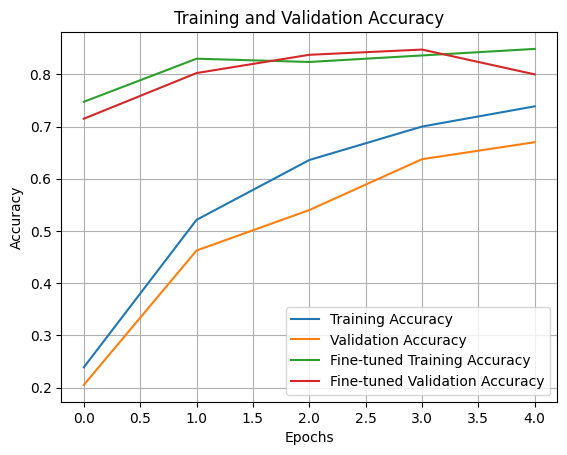

In [21]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

Fine-tuning enhances model accuracy significantly, as shown by the higher performance of the fine-tuned models compared to the original. While training accuracy increases steadily for both, validation accuracy plateaus, indicating overfitting, especially in later epochs. The fine-tuned models exhibit improved initial and overall accuracy, highlighting the effectiveness of this technique. However, the graph also reveals that the most substantial accuracy gains occur during the initial epochs. To achieve better generalization and prevent overfitting, mitigation strategies should be considered.

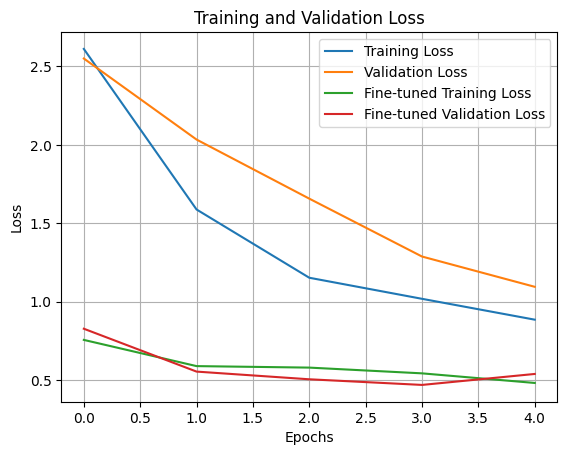

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

The "Training and Validation Loss" graph reveals a significant impact of fine-tuning on model performance.  Initially, the training and validation losses are high for the non-fine-tuned model, indicating poor performance.  However, both losses decrease substantially over epochs, showing the model is learning.  Fine-tuning leads to a much lower starting loss and maintains a consistently low loss, suggesting a more effective and stable model.  The graph also highlights a potential overfitting issue in the non-fine-tuned model, as the validation loss is consistently higher than the training loss.  In contrast, the fine-tuned model exhibits minimal overfitting, demonstrating its ability to generalize well.

##Test model predictions on sample images and visualize results


Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


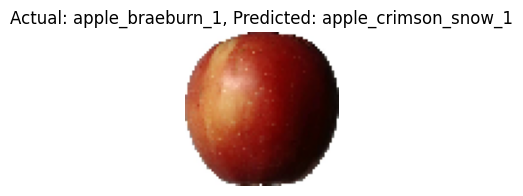

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


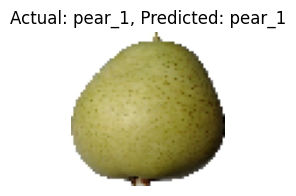

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


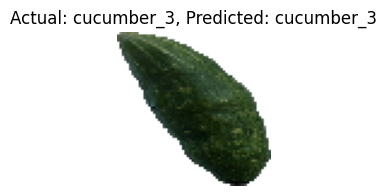

In [23]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

# Function to get class name from predicted index
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Default if index is not found

# Define the function for visualization
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extract the true label dynamically from the directory structure
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract folder name (class)

    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Update the counters
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualize the image with predictions
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Retrieve class index mapping from the training generator
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define a list of image paths without hardcoded labels
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

# Run the predictions and visualization
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)


## Conclusion

In this project, we successfully implemented a fruit classification model using transfer learning with the pre-trained VGG16 model. By fine-tuning the model and applying data augmentation techniques, we enhanced its ability to generalize across different fruit categories, improving overall accuracy. The use of transfer learning proved to be highly effective, enabling us to achieve strong classification performance with limited training data and computational resources. Through model evaluation and visualization of predictions, we demonstrated the reliability of our classifier in correctly identifying various fruits. This project highlights the power of transfer learning in image classification tasks and sets the foundation for further improvements, such as incorporating more diverse datasets or experimenting with other deep learning architectures.